In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

8266217.206972408

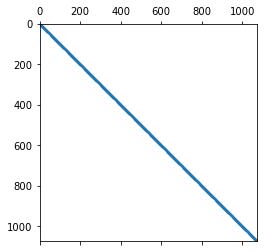

In [2]:
path = "~/Downloads/ch3-3-b2/"
path = "~/Downloads/farm/"
path = "~/Downloads/mesh1em1/"
path = "~/Downloads/pores_1/"
# path = "~/Downloads/bcsstm02/"
path = "~/Downloads/bcsstm08/"
files = list(Path(path).expanduser().glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)

np.linalg.cond(A.toarray())

In [3]:
N = A.shape[0]
# b = np.ones((N))
b = np.random.uniform(size=N)
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

/usr/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


5.727963929017772e-16

In [4]:
def cg(A, b):
    # x = np.random.rand(*b.shape)
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    p = r
    for k in range(1000):
        Ap = A @ p # A.dot(p)
        a = rr / p.T.dot(Ap)
        x = x + a * p
        r = r - a * Ap
        rr1 = r.T.dot(r)
        b = rr1 / rr
        rr = rr1
        p = r + b * p
    return x

cg_sol = cg(A, b)

print(A @ cg_sol - b)


[ 4.99600361e-16 -5.55111512e-16  8.32667268e-17 ... -1.11022302e-16
  0.00000000e+00 -1.66533454e-16]


In [5]:
np.linalg.cond(A.toarray())

8266217.206972408

In [8]:
%matplotlib inline
def check(x, b, numtests=5):
    for _ in range(numtests):
        xbad = x + np.random.normal(size=x.shape)
        d = np.linalg.norm(x-b)
        dbad = np.linalg.norm(xbad-b)
        assert dbad > d


def powers(M, A, r):
    M[0] = r
    for i in range(1, len(M)):
        M[i] = A @ M[i-1]


def scalar_work(i, P):
    W = np.array([[pj @ A @ pi.T for pj in P] for pi in P])
    Winv = np.linalg.inv(W)
    r, s = P[0], len(P)
    m = np.array([r @ p for p in P])
    alpha = Winv @ m
    beta = np.zeros([s, s])

    c = np.zeros(s)
    Akr = r
    c[-1] = - r @ Akr / alpha[-1]
    beta[0] = -c @ Winv
    for k in range(1, s):
        Akr = A @ Akr
        c[:-1] = c[1:]
        rest = sum([alpha[-2-t] * c[-2-t] for t in range(k)])
        c[-1] = -1 / alpha[-1] * ((r @ Akr) + rest)
        beta[k] = -c @ Winv
    return alpha, beta


def s_cg(A, b, s=4):
    x = np.zeros(b.shape)
    P = np.zeros([s, len(b)])
    Q = np.zeros([s, len(b)])
    r0 = b - A @ x
    powers(Q, A, b - A @ x)
    for i in range(100):
        print(f"{i=}")
        print(f"{np.linalg.norm(Q[0])=}")

        alpha, beta = scalar_work(i, Q)
        Q += beta @ P
        orth = Q @ A @ P.T
        # plt.imshow(orth)
        # plt.show()
        # print(f"{orth=}")
        # assert np.all(np.isclose(np.zeros(s), Q @ P.T)), "Not orthogonal."
        x += alpha @ Q
        check(x, b)
        powers(P, A, b - A @ x)
        P, Q = Q, P
    return x


s_cg_sol = s_cg(A, b)
print(np.linalg.norm(s_cg_sol @ A - b))

i=0
np.linalg.norm(Q[0])=18.92633905000084
i=1
np.linalg.norm(Q[0])=44.28922954293631
i=2
np.linalg.norm(Q[0])=32.32409196153736
i=3
np.linalg.norm(Q[0])=237.17797306152266
i=4
np.linalg.norm(Q[0])=2500.038627202502
i=5
np.linalg.norm(Q[0])=7788.417111960307
i=6
np.linalg.norm(Q[0])=5321.559017467926
i=7
np.linalg.norm(Q[0])=503625.8878599761
i=8
np.linalg.norm(Q[0])=62079258.490354225
i=9
np.linalg.norm(Q[0])=178383809.52630228


AssertionError: 